In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist


original_dim = 1000
intermediate_dim = 512
latent_dim = 2
batch_size = 100
epochs = 100
epsilon_std = 1.0


Using TensorFlow backend.
/home/ishanu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ishanu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ishanu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ishanu/.local/lib/python3.7/site-packages/tensorflow/python

In [2]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs



In [3]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)


W0308 15:13:24.038999 139780068177408 deprecation.py:323] From /home/ishanu/.local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split


In [5]:
def splitw(x):
    return np.array([y for y in x])
#.replace('T','1'),replace('G','2').replace('C','3')

In [15]:
FILES=glob.glob('../../datasets/SEQUENCE_/HIV/*seq')
#! wc ../hwdata/hiv/*seq

In [16]:
data=pd.concat([pd.read_csv(i,header=None) for i in FILES])

data1=np.array([x for x in np.squeeze(data)])

data2=np.array([splitw(x.replace('A','1').replace('T','2').replace('G','3').replace('C','4')).astype(int) for x in data1])

data2.shape

(158,)

In [17]:
X=[]
dim1=158
for i in data2:
    X=np.append(X,i[:original_dim])
X=X.reshape(dim1,int(original_dim))
X=X/4.

In [18]:
y=np.array([0*np.ones(60),1*np.ones(37),2*np.ones(23),3*np.ones(38)])
y=np.squeeze(y)
YY=[]
for i in y:
    YY=np.append(YY,i)
YY

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3.])

In [19]:
x_train, x_test, y_train,  y_test=train_test_split(X,YY,test_size=.2)

In [20]:
x_test.shape

(32, 1000)

In [21]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

encoder = Model(x, z_mu)

W0308 15:16:48.905306 139780068177408 deprecation_wrapper.py:119] From /home/ishanu/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 126 samples, validate on 32 samples
Epoch 1/100
126/126 [==============================] - 0s 2ms/step - loss: 730.6079 - val_loss: 710.0266
Epoch 2/100
126/126 [==============================] - 0s 215us/step - loss: 706.6128 - val_loss: 692.2271
Epoch 3/100
126/126 [==============================] - 0s 218us/step - loss: 691.0756 - val_loss: 684.9304
Epoch 4/100
126/126 [==============================] - 0s 189us/step - loss: 684.4137 - val_loss: 682.8571
Epoch 5/100
126/126 [==============================] - 0s 165us/step - loss: 682.6888 - val_loss: 687.4388
Epoch 6/100
126/126 [==============================] - 0s 170us/step - loss: 686.6930 - val_loss: 681.1843
Epoch 7/100
126/126 [==============================] - 0s 190us/step - loss: 680.2318 - val_loss: 682.9039
Epoch 8/100
126/126 [==============================] - 0s 182us/step - loss: 681.0257 - val_loss: 679.8006
Epoch 9/100
126/126 [==============================] - 0s 191us/step - loss: 677.9539 - val_loss: 677

126/126 [==============================] - 0s 170us/step - loss: 638.2154 - val_loss: 641.5199
Epoch 77/100
126/126 [==============================] - 0s 170us/step - loss: 637.3901 - val_loss: 641.5148
Epoch 78/100
126/126 [==============================] - 0s 164us/step - loss: 638.0829 - val_loss: 651.2274
Epoch 79/100
126/126 [==============================] - 0s 159us/step - loss: 650.3891 - val_loss: 655.4589
Epoch 80/100
126/126 [==============================] - 0s 160us/step - loss: 651.4442 - val_loss: 641.4790
Epoch 81/100
126/126 [==============================] - 0s 167us/step - loss: 638.8911 - val_loss: 638.2758
Epoch 82/100
126/126 [==============================] - 0s 164us/step - loss: 636.3103 - val_loss: 639.1813
Epoch 83/100
126/126 [==============================] - 0s 162us/step - loss: 636.0796 - val_loss: 638.9778
Epoch 84/100
126/126 [==============================] - 0s 161us/step - loss: 635.8224 - val_loss: 637.8282
Epoch 85/100
126/126 [===================

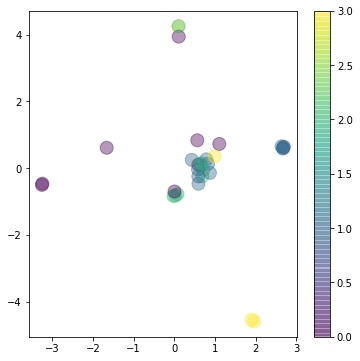

In [22]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=13**2, cmap='viridis')
plt.colorbar()


In [23]:
val=[4,.5]

In [24]:
''.join(np.round(decoder.predict(np.array(val).reshape(1,2))*4)[0].astype(int).astype(str)).replace('1','A').replace('2','T').replace('3','G').replace('4','C')

'GCGGTGTGGGGGGTGGCGTGTGGGGTGGGTCGGGGGGGGCTTGGGTTGGGGCGTTGCGTGGGGGGTGTCGGGTATTTTGGGTGGGGGGTGGGCGGGATGTTGTGGGGGGGGGGGTTGTGTGTGGGGGGGTGTTGTGGTGTGGGGGGTGTGGCGTGGTGTGTGGGGGGTTGTGGTGTTGGGGGGGCGGGGGTTGTGGGTGTGGTTTGGGTATGTGTTTGGGGTGTTTGGCGGGGTGGGGTGGTGTGGGGTGGGGGGTGGGGGGTGGGTGTGTGTGTTTGGGGGGGGGGTGGGGTTTTGGGGTTATATGTTGTGGTGGGGTGGGGTGTTTGTTTGTTTGGGTGGGGGGTTGGTGTTTTGGTTTGGGGGGTGTTTGTGTTTGTTGGGTTTTTGGTGTTGTTTGTGGTGTTGGTTTTTTTTTATTTTTTGTTTTTGTTTGAGGTTGGGGTGTGTGTGGTGTAGATGTTGTGGGTGGTTTTGGGTGGGGTGTAGTAAGTTGTTTTGGGGGTTGTGTTTTTTTGGGTGTGGTTGTTGGTTGGGTTCTGTTTGTTTTTTTTGTTGTTTTATGATTTGTTTTTTGTTTTGGTTGGGTGGATGGTTTTGGTGGTTGGGTTGTTGTTTTAGTGTGGTTTGTTGGTGTTGTGTAGTTTGTGGTTGTTGGTTTGTTTTGTTTGTTTTGTGGTGTTGTTGGTGGTGGTGTGAGATGATTGTGGGTGTAGGTGTGGGTTATTGGGGGTATTGGTGTGTTGTTGGGGTGTGTTTTTGTAGTTGTGGGGTTTGGTGGTTGTTGTTGTGTTGGTTTGGGATTTGTTGGTGTTGTTTTTGGGTTGTGGGGTGTTGTTGTTGGGTTGTTTTGTGGTTTTGGTGTTGGTGGGTGGGGTGTTGTTGTAGTGTGGTTGGGTTTGGGAGGGGGGGGTGTTGTTGGAGGGTTTGTATGTTTTTTTGTTTGGAGGTTTTTTGTAGGTGGAGTTGTGTTTTGTGTGGTGGGAGTGGTGGGTGGGG

In [25]:
val=[-2,1]

In [26]:
''.join(np.round(decoder.predict(np.array(val).reshape(1,2))*4)[0].astype(int).astype(str)).replace('1','A').replace('2','T').replace('3','G').replace('4','C')

'CGGGTATCTTGTGTGCCCTCAGATCGTTTTGTCAGTGATGAATATCTCGTGCAGTGGCTCCCTTTCAGGGACTTTAAAGCGAAAGTTAGACCTGTTTAGATCTCTCGACTCAGGACTCGTCTTGCTGAAGTGCACACGGCATGTGGCGTTTGCGGCGGCTGGTGTGTTCGCCTAATTTTTTTTGACTTGCTGAGGCTAGAAGGTGATAGATTGGTGCGAGAGCGTCATTATTAAGAGTCTTAAATTTTGACACCGGGGAAAGAATTAAGTTAAATCCAGTGTCAAAGATATTCTATATTATGAAACTCCAAGTCTTTGGAAGGAGGTTGGTGTAATTTTGTGGTGTTTTCCGTGCCGTTTTGTTTTGAGGTGTTGGCTTAATGGTTTTGGTTGATTATCTTGATCGTGGTGTTGAGTGTGTAGGAAAGTTGTTGTATGGTGTTTATATGGGTTTTGTTTGGGTCTATTTTGATGATTTAAGTTATTAGGATCTGTGGTCGAAGTAGGCGTAATTGAAAATAATGTAGTTTGTAATGAAAGGTGAGGTAAAATGTGTGTAGTGTTAAGCTGGTTTGAAGTTAAATGTGAGGTTATATAAGCGTGTTTGGTTTATGTTTGAGTGGTAAATGGTTTTCTTGTCTATTGGGCGTTTTTGTTTTAAGGGGTGGGGTATTGATTTTTTTGTTATGGGTGTTTGCCTTTTGTAATATCCTATTTTTGTTGTATTTGTTTATGTTGCGGCCCGTTAAGATGAAAATGCGATGTAATTAGGGGAGTTGGGGTATTTTCGTGCTTGGTAATTGTTATTTTATTCGATTTTTGGGTTGGTTGTTTAATTGTTAGGTTTTTTGCTTTGGGTGCTTTGGCGTATTGTTCTGTGCGATTTGTTTGAGCTTGGGGTAGTGTTTTTGGTTGTATTTTTTGTAGCCGTTGTGTATTATTATGTTGGTGTTGTATTTATCCTGCTTATCCTTGATGTTTAATTGTTAATTGTGGGTT

## HW:
---
    1. what are the hyper parameters you can tune?
    2. Tune the models so that the distribution is more compact.
    3. Investigate other segments (POL, ENV, INTEGRASE, Reverse-transcriptase, and complete genome)
    4. Blast it against the origin sequence data to investigate if we are closer to the clinical subtypes that we shpuld be closer to
    5. How well can we actually use this to generate new samples (sequences of hiv clinical subtypes not in the dataset?)